In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: may have to add '..' if move from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp

# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')
# pd.read_clipboard()

# For experiments
# path to astrobot roo
ROOT_DIR

# path to this package from experiments folder
PACKAGE_FPATH_FOR_EXPERIMENTS

# path to epw from experiments folder
EPW_FPATH_FOR_EXPERIMENTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/mnt/c/Users/saeran2/master/git/astrobot/resources/epw/philadelphia/philadelphia.epw'

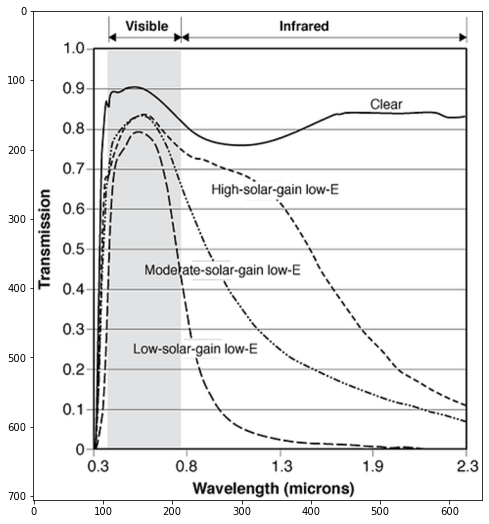

In [4]:
from PIL import Image 

ref_fpath = os.path.join(os.getcwd(),  'shgc_tviz_ref.png')
ref_img = np.asarray(Image.open(ref_fpath, 'r'))

_, a = plt.subplots(figsize=(9, 9))
plt.imshow(ref_img, cmap='gray')

16


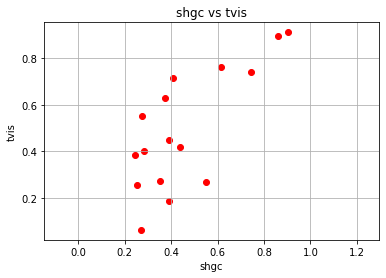

In [55]:
def viz_exp_ezplot(a=None, invert=False):
    """make clean plot for experiments."""
    if a is None:
        _, a = plt.subplots()
    a.grid()
    a.axis('equal')
    
    # Labels
    xlabel, ylabel = 'shgc', 'tvis' 
    if invert:
        xlabel, ylabel = 'tvis', 'shgc'
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    a.set_title('{} vs {}'.format(xlabel, ylabel))
    return a 
    
# Table 2 SHGC/Tviz of Various Glazing Systems for ASTM Standard Solar Spectrum 
# McCluney, 1996. 

shgc_data = np.array([
    [0.905, 0.860, 0.742, 0.616, 0.372, 0.392, 0.244, 0.408, 0.439, 
     0.549, 0.272, 0.391, 0.509, 0.371, 0.276, 0.254, 0.352, 0.283]])

tviz_data = np.array([
    [0.913, 0.898, 0.740, 0.762, 0.628, 0.447, 0.384, 0.716, 0.420,
     0.270, 0.062, 0.188, 0.996, 0.995, 0.554, 0.254, 0.271, 0.400]])

# Remove outliers (how can tviz=1 if shgc < 1)
idx = np.where(tviz_data < 0.95)
shgc_data = shgc_data[idx]
tviz_data = tviz_data[idx]

data_num = shgc_data.shape[0]
print(data_num)

viz_exp_ezplot().scatter(shgc_data, tviz_data, color='red')



In [60]:
# Create regression model
# add 1s row so that we have a bias
# X: 1, 16
# y: 1, 16
#  
X = np.array([shgc_data, np.ones_like(shgc_data)]) 
y = tviz_data

# 1. Projection matrix 
X = X.T  # 16, 1
P = X @ np.linalg.pinv(X.T @ X) @ X.T
print('Proj matrix', P.shape)  # 16, 16

# Project y onto X plane 
yhat1 = P @ y

# 2. Weights matrix 
B = np.linalg.pinv(X.T @ X) @ X.T @ y
print('Weights matrix', B.shape)  # (2, )
yhat2 = X @ B 

assert np.sum(yhat1 - yhat2) < 1e-10

# slope, bias = B  # extract slope and bias


Proj matrix (16, 16)
Weights matrix (2,)


[0.90535007 0.07800939]


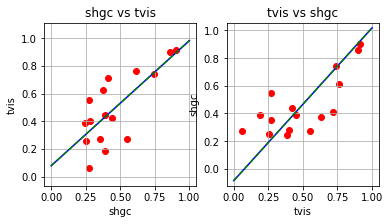

In [74]:
print(B)

pred_tviz = lambda _x: (B[0] * _x) + B[1]
pred_shgc = lambda _x: (_x / B[0]) - (B[1] / B[0])  # invert function  

_, a = plt.subplots(1, 2, figsize=(6, 3))

# tvis predict
_shgc = np.linspace(0, 1, data_num)
a[0] = viz_exp_ezplot(a[0])
a[0].scatter(shgc_data, tviz_data, color='red')
_ = a[0].plot(_shgc, pred_tviz(_shgc), color='blue')
# check inversion 
_ = a[0].plot(_shgc, pred_tviz(pred_shgc(pred_tviz(_shgc))), 
              color='green', linestyle='--')

# shgc predict
_tviz = np.linspace(0, 1, data_num)
a[1] = viz_exp_ezplot(a[1], invert=True)
a[1].scatter(tviz_data, shgc_data, color='red')
_ = a[1].plot(_tviz, pred_shgc(_tviz), color='blue')
_ = a[1].plot(_tviz, pred_shgc(pred_tviz(pred_shgc(_tviz))), 
              color='green', linestyle='--')


In [ ]:

# Test intuition

